# Libraries

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text
from sqlalchemy.exc import SQLAlchemyError
from sqlalchemy import create_engine, DDL

# Pandas settings

In [2]:
# Set option to display all rows
pd.set_option('display.max_rows', 50)

# Database Connection

In [3]:
# Connection parameters for connecting to the PostgreSQL server
DATABASE = 'fraud'
USER = 'postgres'
PASSWORD = 'welcome1'
HOST = 'localhost'
PORT = '5432' # Default PostgreSQL port
DB_URI = f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}'

In [4]:
# Create an engine
engine = create_engine(DB_URI)

In [5]:
# Create a session
Session = sessionmaker(bind=engine)
session = Session()

# Analysis

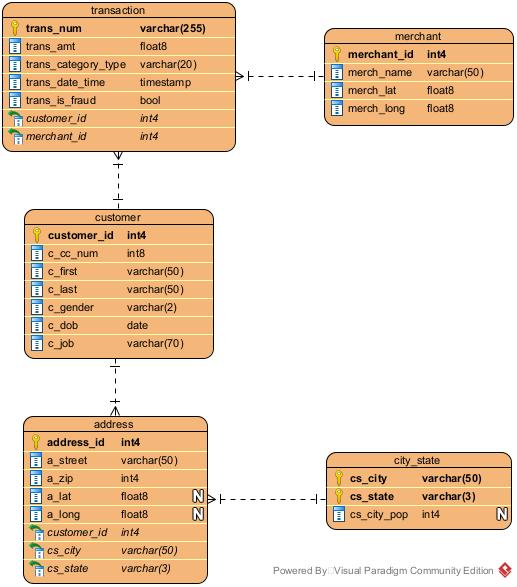

# 5 Queries

### Query 1 - Exploring Transaction Details (Multi-Table Join)

#### comprehensive view of transactions. Join the transaction, customer, and merchant tables to retrieve transaction numbers, amounts, customer names, and merchant names. Use aliases to clarify your SELECT statement. This will give a foundational understanding of the transactional activity in the dataset, such as who is spending where and how much.

In [6]:
# Exploring Transaction Details
query1 = """
    SELECT
        c.customer_id,
        c.c_job,
        c.c_gender,
        EXTRACT(YEAR FROM AGE('2020-12-31', c_dob)) AS age,
        a.cs_city,
        a.cs_state,
        a.a_zip,
        t.trans_date_time,
        m.merch_name,
        t.trans_category_type,
        t.trans_amt,
        t.trans_is_fraud
    FROM
        customer c
        JOIN address a ON c.customer_id = a.customer_id
        JOIN transaction t ON c.customer_id = t.customer_id
        JOIN merchant m ON t.merchant_id = m.merchant_id
    ORDER BY
        t.trans_amt;
   
"""

In [7]:
query1_df = pd.read_sql_query(query1,engine)
#query1_df['trans_amt'] = query1_df['trans_amt'].apply(lambda x:"{:,.2f}".format(x))
query1_df

,customer_id,c_job,c_gender,age,cs_city,cs_state,a_zip,trans_date_time,merch_name,trans_category_type,trans_amt,trans_is_fraud
0,95423571,Museum/gallery exhibitions officer,F,28.0,Colorado Springs,CO,80951,2020-06-29 14:31:00,Gerlach Inc,shopping net,1.00,False
1,25226820,Museum/gallery conservator,F,32.0,Clifton,SC,29324,2020-07-07 15:52:00,"Baumbach, Hodkiewicz and Walsh",shopping pos,1.00,False
2,1627715,Farm manager,F,28.0,Amanda,OH,43102,2020-06-22 15:57:00,"Langworth, Boehm and Gulgowski",shopping net,1.00,False
3,70115071,Administrator,M,66.0,Lohrville,IA,51453,2020-07-06 06:27:00,Kuhn LLC,shopping pos,1.00,False
4,71467364,"Exhibitions officer, museum/gallery",F,25.0,Elberta,MI,49628,2020-06-22 19:49:00,"Kuhic, Bins and Pfeffer",shopping net,1.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...
555714,83765334,Surgeon,M,21.0,Conway,NH,3818,2020-12-16 21:16:00,Boyer-Haley,travel,16339.26,False
555715,89989635,Health physicist,F,49.0,Newhall,CA,91321,2020-09-21 12:02:00,Johnston-Casper,travel,16837.08,False
555716,64061725,Hospital doctor,M,65.0,Pembroke,NC,28372,2020-11-27 14:54:00,Kovacek Ltd,travel,19364.91,False
555717,49735544,Higher education careers adviser,F,26.0,Jay,FL,32565,2020-12-22 21:30:00,Corwin-Romaguera,travel,21437.71,False


In [8]:
# Analysis
# when ordered by trans_amt DESC, the most expensive amount is in travel category amounting to 22,768.11
# when ordered by trans_amt ASC, the lowest amount is 1.00, this probably a website verifying the authenticity payment method to to prevent fraudulent activities and ensure that the payment method is valid.

### Query 2 Identifying Frequent Customers Top 100 (Creating a View)

#### A view that ranks customers by their number of transactions. This view will consolidate customer IDs, names, and the count of their transactions. You can then query this view to find your most frequent customers. This insight is crucial for identifying valuable customers or those who might warrant further scrutiny for the frequency of their activities.

In [ ]:
# Creating a View - Identifying Frequent Customers
query2 = text("""
                CREATE VIEW top_customers
                AS
                    SELECT
                        c.customer_id,
                        c.c_gender,
                        EXTRACT(YEAR FROM AGE('2020-12-31', c_dob)) AS age,
                        c.c_job,
                        a.a_zip,
                        a.cs_city,
                        a.cs_state,
                        COUNT(t.trans_num) AS num_of_transaction,
                        SUM(t.trans_amt) AS total_amount,
                        COUNT(CASE WHEN trans_is_fraud = True THEN 1 ELSE NULL END ) AS no_of_fraud
                    FROM 
                        customer c
                        JOIN transaction t ON c.customer_id = t.customer_id
                        JOIN address a ON c.customer_id = a.customer_id
                    GROUP BY c.customer_id, c.c_job, c.c_gender,a.a_zip, a.cs_city, a.cs_state
                    LIMIT 100;
""")
# Execute the query
session.execute(query2)
session.commit()

In [10]:
session.rollback()

In [11]:
query2 = """
        SELECT *
        FROM
            top_customers
        ORDER BY num_of_transaction DESC
        ;
"""

In [12]:
query2_df = pd.read_sql_query(query2,engine)
#query2_df['total_amount'] = query2_df['total_amount'].apply(lambda x: "${:,.2f}".format(x))
#query2_df['num_of_transaction'] = query2_df['num_of_transaction'].apply(lambda x:"{:,}".format(x))
query2_df

,customer_id,c_gender,age,c_job,a_zip,cs_city,cs_state,num_of_transaction,total_amount,no_of_fraud
0,2279629,M,24.0,Pensions consultant,40077,Westport,KY,1428,98991.93,0
1,916035,F,48.0,"Designer, exhibition/display",92585,Sun City,CA,1352,117944.10,0
2,6779390,F,45.0,Firefighter,46254,Indianapolis,IN,1339,114631.63,0
3,9794581,F,32.0,Tax inspector,65072,Rocky Mount,MO,1334,74756.38,0
4,8548529,F,35.0,Regulatory affairs officer,21872,Whaleyville,MD,1301,66376.27,0
...,...,...,...,...,...,...,...,...,...,...
95,10359342,F,68.0,Magazine journalist,62266,New Memphis,IL,211,10807.69,0
96,4294505,F,84.0,"Biochemist, clinical",25832,Daniels,WV,209,12838.53,0
97,7150172,M,33.0,Comptroller,92101,San Diego,CA,204,15149.16,0
98,10180169,M,81.0,Estate manager/land agent,50527,Curlew,IA,195,11102.84,0


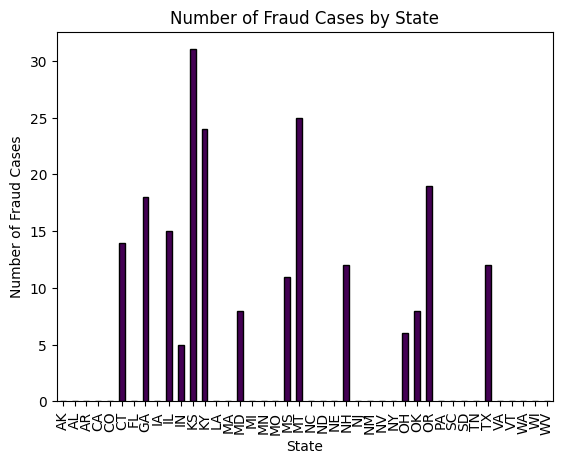

In [13]:
# Group by 'cs_state' and sum the 'no_of_fraud' column
fraud_by_state = query2_df.groupby('cs_state')['no_of_fraud'].sum()

# Plot the bar chart using a colormap
fraud_by_state.plot(kind='bar', cmap='viridis', edgecolor='k')

# Add labels and title
plt.xlabel('State')
plt.ylabel('Number of Fraud Cases')
plt.title('Number of Fraud Cases by State')

# Show the plot
plt.show()

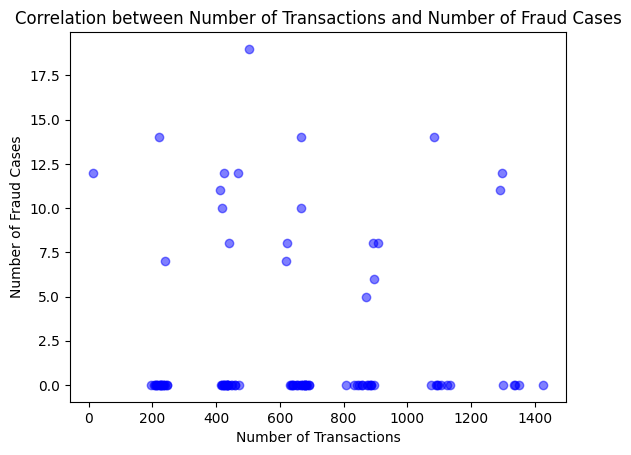

In [14]:
# Plot the scatter plot
plt.scatter(query2_df['num_of_transaction'], query2_df['no_of_fraud'], color='blue', alpha=0.5)

# Set the title and labels
plt.title('Correlation between Number of Transactions and Number of Fraud Cases')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Fraud Cases')

# Display the plot
plt.show()

### Query 3 Analyzing Transaction Patterns

#### With a CTE, this will calculate the average transaction amount of the whole table and compare it against individual transactions to find those well above or below this average. This could indicate unusually large or small transactions, which could be indicative of errors or potential fraud.

In [15]:
# Common Table Expression (CTE) - Analyzing Transaction Patterns

query3 = """
        WITH median_transaction AS (
            SELECT 
                c.customer_id,
                PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY t.trans_amt) AS median_trans_amt                       
            FROM customer c
                JOIN transaction t ON t.customer_id = c.customer_id
            GROUP BY c.customer_id
        )
        
        SELECT 
            c.customer_id,
            c.c_gender,
            c.c_job,
            m.merch_name,
            t.trans_category_type,
            t.trans_date_time,
            t.trans_amt,
            med.median_trans_amt,
            ((t.trans_amt - med.median_trans_amt)/ med.median_trans_amt) * 100 AS percentage_diff,
            t.trans_is_fraud
        FROM customer c
            JOIN transaction t ON c.customer_id = t.customer_id
            JOIN merchant m ON t.merchant_id = m.merchant_id
            JOIN median_transaction med ON c.customer_id = med.customer_id
        --WHERE c.customer_id IN (SELECT customer_id FROM top_customers)
        ORDER BY percentage_diff DESC;                   
"""

In [16]:
query_df3 = pd.read_sql_query(query3, engine)
#query_df3['trans_amt'] = query_df3['trans_amt'].apply( lambda x: '${:,.2f}'.format(x))
#query_df3['median_trans_amt'] = query_df3['median_trans_amt'].apply(lambda x: '${:,.2f}'.format(x))
#query_df3['percentage_diff'] = query_df3['percentage_diff'].apply(lambda x:'{:,.2f}%'.format(x))
query_df3

,customer_id,c_gender,c_job,merch_name,trans_category_type,trans_date_time,trans_amt,median_trans_amt,percentage_diff,trans_is_fraud
0,83765334,M,Surgeon,Boyer-Haley,travel,2020-12-16 21:16:00,16339.26,22.960,71064.024390,False
1,163011,F,"Engineer, control and instrumentation",Kozey-McDermott,travel,2020-12-27 15:58:00,22768.11,35.460,64107.868020,False
2,49735544,F,Higher education careers adviser,Corwin-Romaguera,travel,2020-12-22 21:30:00,21437.71,50.430,42409.835415,False
3,50479522,F,Counsellor,"Hagenes, Hermann and Stroman",travel,2020-07-03 18:13:00,13149.15,32.380,40508.863496,False
4,9488913,M,Biomedical engineer,"Schroeder, Wolff and Hermiston",travel,2020-10-19 18:11:00,12969.90,32.895,39328.180575,False
...,...,...,...,...,...,...,...,...,...,...
555714,19654975,M,Armed forces training and education officer,Luettgen PLC,gas transport,2020-07-30 00:52:00,7.84,774.140,-98.987263,True
555715,87292974,M,Commissioning editor,Huels-Nolan,gas transport,2020-12-02 00:07:00,9.16,955.500,-99.041340,True
555716,69296734,M,Historic buildings inspector/conservation officer,"Raynor, Feest and Miller",gas transport,2020-09-01 09:19:00,7.99,837.825,-99.046340,True
555717,19654975,M,Armed forces training and education officer,Prohaska-Murray,gas transport,2020-07-31 03:43:00,7.00,774.140,-99.095771,True


In [17]:
# Compute for the range
query_df3['percentage_diff'] = query_df3['percentage_diff'].astype(float)
mean = query_df3['percentage_diff'].mean()
std_dev = query_df3['percentage_diff'].std()
low_range = mean - std_dev
high_range = mean + std_dev

In [18]:
low_range, high_range

(-349.0878980045989, 467.2374467942722)

In [28]:
# Common Table Expression (CTE) - Analyzing Transaction Patterns

query3_1 = """
        WITH median_transaction AS (
            SELECT 
                c.customer_id,
                PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY t.trans_amt) AS median_trans_amt                       FROM customer c
                JOIN transaction t ON t.customer_id = c.customer_id
            GROUP BY c.customer_id
        )
        
        SELECT 
            c.customer_id,
            c.c_gender,
            c.c_job,
            m.merch_name,
            t.trans_num,
            t.trans_category_type,
            t.trans_date_time,
            t.trans_amt,
            med.median_trans_amt,
            ((t.trans_amt - med.median_trans_amt)/ med.median_trans_amt) * 100 AS percentage_diff,
            CASE
                WHEN ((t.trans_amt - med.median_trans_amt)/ med.median_trans_amt) * 100 < -349.09 THEN 'Low Risk'
                WHEN ((t.trans_amt - med.median_trans_amt)/ med.median_trans_amt) * 100 > 467.24 THEN 'High Risk'
                ELSE 'Within Range'
                END AS percentage_diff_category,
            t.trans_is_fraud
        FROM customer c
            JOIN transaction t ON c.customer_id = t.customer_id
            JOIN merchant m ON t.merchant_id = m.merchant_id
            JOIN median_transaction med ON c.customer_id = med.customer_id
        --WHERE c.customer_id IN (SELECT customer_id FROM top_customers)
        ORDER BY percentage_diff_category DESC
        ;
                   
"""

In [29]:
query_df3_1 = pd.read_sql_query(query3_1, engine)
#query_df3_1['trans_amt'] = query_df3_1['trans_amt'].apply( lambda x: '${:,.2f}'.format(x))
#query_df3_1['median_trans_amt'] = query_df3_1['median_trans_amt'].apply(lambda x: '${:,.2f}'.format(x))
query_df3_1

,customer_id,c_gender,c_job,merch_name,trans_num,trans_category_type,trans_date_time,trans_amt,median_trans_amt,percentage_diff,percentage_diff_category,trans_is_fraud
0,45452775,F,Equality and diversity officer,Streich Ltd,30de0fd24b22fcf3c848e6cb16b8b09e,home,2020-07-29 18:36:00,53.50,35.570,50.407647,Within Range,False
1,18702918,F,"Sales professional, IT",Sporer-Keebler,324cc204407e99f51b0d6ca0055005e7,personal care,2020-06-21 12:14:00,29.84,35.590,-16.156224,Within Range,False
2,95127892,F,"Librarian, public","Swaniawski, Nitzsche and Welch",c81755dbbbea9d5c77f094348a7579be,health fitness,2020-06-21 12:14:00,41.28,54.290,-23.963898,Within Range,False
3,59734903,M,Set designer,Haley Group,2159175b9efe66dc301f149d3d5abf8c,misc pos,2020-06-21 12:15:00,60.05,39.680,51.335685,Within Range,False
4,81017923,M,Furniture designer,Johnston-Casper,57ff021bd3f328f8738bb535c302a31b,travel,2020-06-21 12:15:00,3.19,37.670,-91.531723,Within Range,False
...,...,...,...,...,...,...,...,...,...,...,...,...
555714,96109975,F,Animator,Beier LLC,b9995f2d2578f73b9ed2bdbfff8f8e43,entertainment,2020-12-31 14:41:00,503.28,57.330,777.864992,High Risk,False
555715,61257002,M,"Programmer, multimedia",Hackett Group,e0d2fbd5edf77b51a84c9acdf0395a9e,travel,2020-12-25 13:39:00,1006.58,41.420,2330.178658,High Risk,False
555716,49088409,F,"Education officer, community",Stark-Koss,9345fa91dab8ff003f69ce729dd4d891,home,2020-12-26 22:48:00,202.52,25.690,688.322304,High Risk,False
555717,44642268,F,Acupuncturist,Lemke-Gutmann,643fbe2a709d355eadc5f0375225840d,shopping net,2020-12-24 09:25:00,337.03,54.970,513.116245,High Risk,False


In [33]:
# using pandas to accurately identify the range per customer
# calculate median and std. dev

customer_stats = query_df3.groupby('customer_id')['percentage_diff'].agg(['median','std']).reset_index()

#Calculate the high and low range per customer
customer_stats['low_range'] = customer_stats['median'] - customer_stats['std']
customer_stats['high_range'] = customer_stats['median'] + customer_stats['std']

In [34]:
customer_stats.head(3)

,customer_id,median,std,low_range,high_range
0,146774,0.000000e+00,274.986386,-274.986386,274.986386
1,163011,0.000000e+00,2474.398763,-2474.398763,2474.398763
2,277372,6.591949e-15,277.022642,-277.022642,277.022642


In [35]:
#merging customer_stats with query_df3
query_df3['customer_id'] = query_df3['customer_id'].astype(int)
customer_stats['customer_id'] = customer_stats['customer_id'].astype(int)

query_df3_p = query_df3.merge(customer_stats[['customer_id','low_range','high_range']], on='customer_id', how = 'left')
query_df3_p.head(5)

,customer_id,c_gender,c_job,merch_name,trans_category_type,trans_date_time,trans_amt,median_trans_amt,percentage_diff,trans_is_fraud,low_range,high_range
0,83765334,M,Surgeon,Boyer-Haley,travel,2020-12-16 21:16:00,16339.26,22.960,71064.024390,False,-2985.255141,2985.255141
1,163011,F,"Engineer, control and instrumentation",Kozey-McDermott,travel,2020-12-27 15:58:00,22768.11,35.460,64107.868020,False,-2474.398763,2474.398763
2,49735544,F,Higher education careers adviser,Corwin-Romaguera,travel,2020-12-22 21:30:00,21437.71,50.430,42409.835415,False,-2740.233251,2740.233251
3,50479522,F,Counsellor,"Hagenes, Hermann and Stroman",travel,2020-07-03 18:13:00,13149.15,32.380,40508.863496,False,-1323.005571,1323.005571
4,9488913,M,Biomedical engineer,"Schroeder, Wolff and Hermiston",travel,2020-10-19 18:11:00,12969.90,32.895,39328.180575,False,-1341.565100,1341.565100


In [36]:
# defining conditions using numpy
conditions = [query_df3_p['percentage_diff'] < query_df3_p['low_range'],
              query_df3_p['percentage_diff'] > query_df3_p['high_range']]
choices = ['Low Risk','High Risk'] 
default = 'Within Range' 

# apply the conditions above in the df
query_df3_p['deviation_category'] = np.select(conditions, choices, default = default)
query_df3_p.head(2)

,customer_id,c_gender,c_job,merch_name,trans_category_type,trans_date_time,trans_amt,median_trans_amt,percentage_diff,trans_is_fraud,low_range,high_range,deviation_category
0,83765334,M,Surgeon,Boyer-Haley,travel,2020-12-16 21:16:00,16339.26,22.96,71064.02439,False,-2985.255141,2985.255141,High Risk
1,163011,F,"Engineer, control and instrumentation",Kozey-McDermott,travel,2020-12-27 15:58:00,22768.11,35.46,64107.86802,False,-2474.398763,2474.398763,High Risk


In [37]:
Cust3603551 = query_df3_p[query_df3_p['customer_id'] == 3603551]
Cust3603551

,customer_id,c_gender,c_job,merch_name,trans_category_type,trans_date_time,trans_amt,median_trans_amt,percentage_diff,trans_is_fraud,low_range,high_range,deviation_category
195598,3603551,M,Chemical engineer,"Daugherty, Pouros and Beahan",shopping pos,2020-09-30 23:41:00,1320.92,911.105,44.979997,True,-55.118906,55.118906,Within Range
242431,3603551,M,Chemical engineer,"Reichert, Huels and Hoppe",shopping net,2020-10-01 22:28:00,1075.70,911.105,18.065426,True,-55.118906,55.118906,Within Range
253550,3603551,M,Chemical engineer,Lemke-Gutmann,shopping net,2020-10-01 22:22:00,1020.62,911.105,12.020020,True,-55.118906,55.118906,Within Range
254278,3603551,M,Chemical engineer,Price Inc,shopping net,2020-09-30 20:41:00,1017.05,911.105,11.628188,True,-55.118906,55.118906,Within Range
269278,3603551,M,Chemical engineer,"Stanton, Jakubowski and Baumbach",shopping net,2020-10-01 23:19:00,944.94,911.105,3.713622,True,-55.118906,55.118906,Within Range
269674,3603551,M,Chemical engineer,"Labadie, Treutel and Bode",shopping net,2020-09-30 22:10:00,943.12,911.105,3.513865,True,-55.118906,55.118906,Within Range
287061,3603551,M,Chemical engineer,"Reichert, Rowe and Mraz",shopping net,2020-09-30 23:22:00,879.09,911.105,-3.513865,True,-55.118906,55.118906,Within Range
313025,3603551,M,Chemical engineer,Rempel Inc,shopping net,2020-09-30 22:34:00,752.02,911.105,-17.460666,True,-55.118906,55.118906,Within Range
555708,3603551,M,Chemical engineer,"Reilly, Heaney and Cole",gas transport,2020-09-30 07:18:00,11.50,911.105,-98.737796,True,-55.118906,55.118906,Low Risk
555710,3603551,M,Chemical engineer,"Larson, Quitzon and Spencer",travel,2020-09-30 23:17:00,10.03,911.105,-98.899139,True,-55.118906,55.118906,Low Risk


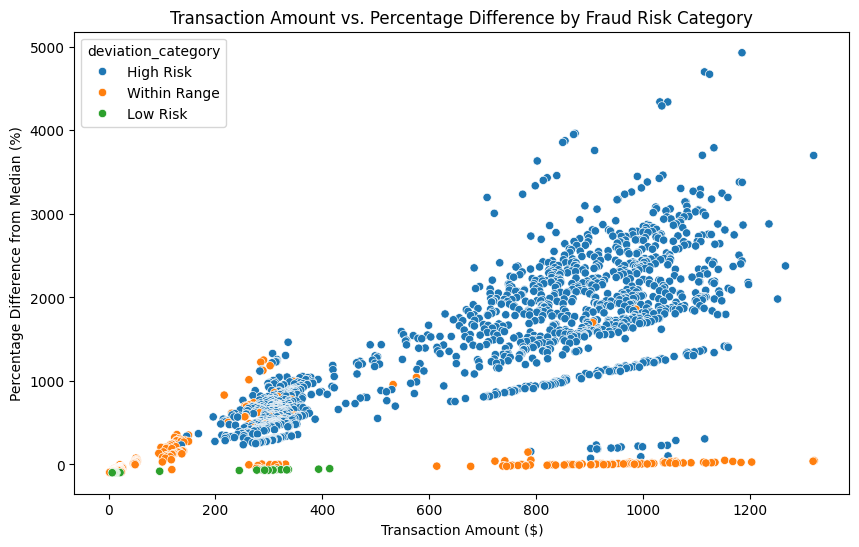

In [59]:
# Filter all tagged as fraudulent activities
filtered_query= query_df3_p.loc[query_df3_p['trans_is_fraud'] == True]

# create a scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trans_amt', y='percentage_diff', hue='deviation_category', data=filtered_query)

# Adding labels and title
plt.title('Transaction Amount vs. Percentage Difference by Fraud Risk Category')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Percentage Difference from Median (%)')

# Show the plot
plt.show()


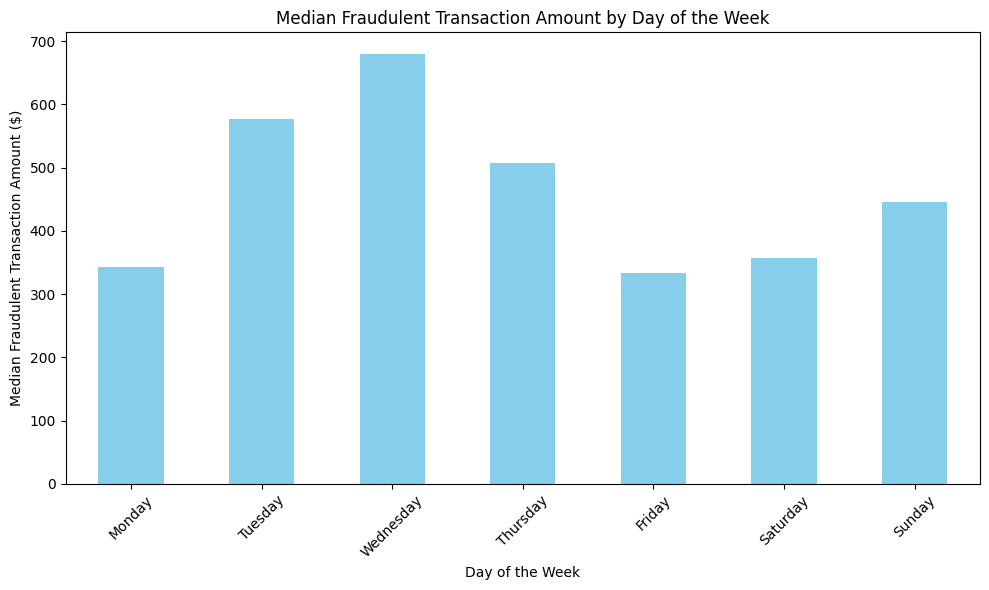

In [40]:
# Extract the day of the week from 'trans_date_time'
query_df3_p['day_of_week'] = query_df3_p['trans_date_time'].dt.day_name()

# Filter to include only fraudulent transactions
fraud_df = query_df3_p[query_df3_p['trans_is_fraud'] == True]

# Group by day of the week and calculate the median of fraud amounts
median_fraud_by_day = fraud_df.groupby('day_of_week')['trans_amt'].median().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# create a bar graph
plt.figure(figsize=(10, 6))
median_fraud_by_day.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Median Fraudulent Transaction Amount ($)')
plt.title('Median Fraudulent Transaction Amount by Day of the Week')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

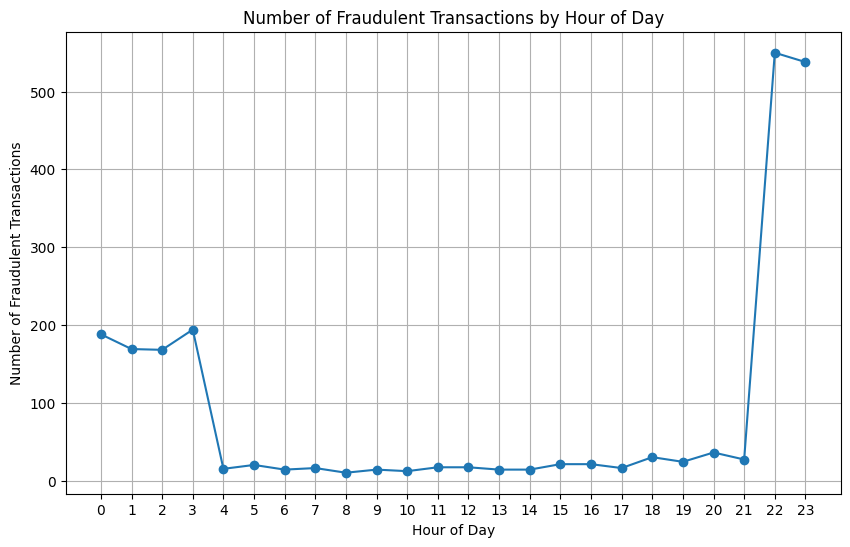

In [42]:
# Extract hour of day for each transaction
query_df3_p['hour_of_day'] = query_df3_p['trans_date_time'].dt.hour

# Group by hour of day and count number of frauds
fraud_count_per_hour = query_df3_p[query_df3_p['trans_is_fraud']].groupby('hour_of_day').size()

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(fraud_count_per_hour.index, fraud_count_per_hour.values, marker='o')

# Labeling the chart
plt.title('Number of Fraudulent Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(range(0, 24))  
plt.grid(True)

# Show the chart
plt.show()

### Query 4

#### To deepen the analysis of fraudulent transactions, this query aims to explore the relationship between fraudulent activities, the merchants where these activities occur, and the demographics of the customers involved. 

In [43]:
query4 = """
         WITH cust_demo AS (
            SELECT 
                c.customer_id,
                EXTRACT(YEAR FROM AGE('2020-12-31', c_dob)) AS age,
                c.c_job,
                c.c_gender,
                a.cs_city,
                a.cs_state
                               
            FROM customer c
                JOIN address a ON c.customer_id = a.customer_id
            GROUP BY c.customer_id, a.cs_city, a.cs_state, c.c_gender, c.c_job, age
            )
            SELECT
                cd.*,
                SUM(t.trans_amt) As total_trans_amt,
                --t.trans_category_type,
                --m.merch_name,
                COUNT(*) AS no_of_fraud
            FROM cust_demo cd
                JOIN transaction t ON cd.customer_id = t.customer_id
                JOIN merchant m ON t.merchant_id = m.merchant_id
            WHERE t.trans_is_fraud = True AND cd.customer_id IN (SELECT customer_id FROM top_customers)
            GROUP BY cd.customer_id, cd.age, cd.c_job, cd.cs_state, cd.cs_city, cd.c_gender
            ORDER BY no_of_fraud DESC
        ;
        
"""

In [44]:
query_df4 = pd.read_sql_query(query4, engine)
query_df4

,customer_id,age,c_job,c_gender,cs_city,cs_state,total_trans_amt,no_of_fraud
0,5936811,23.0,Gaffer,F,Burrton,KS,12002.06,19
1,7303638,56.0,Further education lecturer,M,Turner,MT,6863.58,14
2,9533425,21.0,"Therapist, sports",F,Smiths Grove,KY,5839.30,14
3,4279521,43.0,Broadcast presenter,F,Preston,CT,5782.20,14
4,3603551,18.0,Chemical engineer,M,Morrowville,KS,7993.74,12
5,10580441,52.0,"Engineer, biomedical",F,Stayton,OR,8195.87,12
6,1529474,44.0,Press sub,F,Thrall,TX,5685.68,12
7,5077091,65.0,"Scientist, research (medical)",M,Belmont,NH,5489.25,12
8,146774,54.0,"Scientist, clinical (histocompatibility and im...",F,Ridgeland,MS,3950.54,11
9,3684340,48.0,Water engineer,F,Heart Butte,MT,3536.49,11


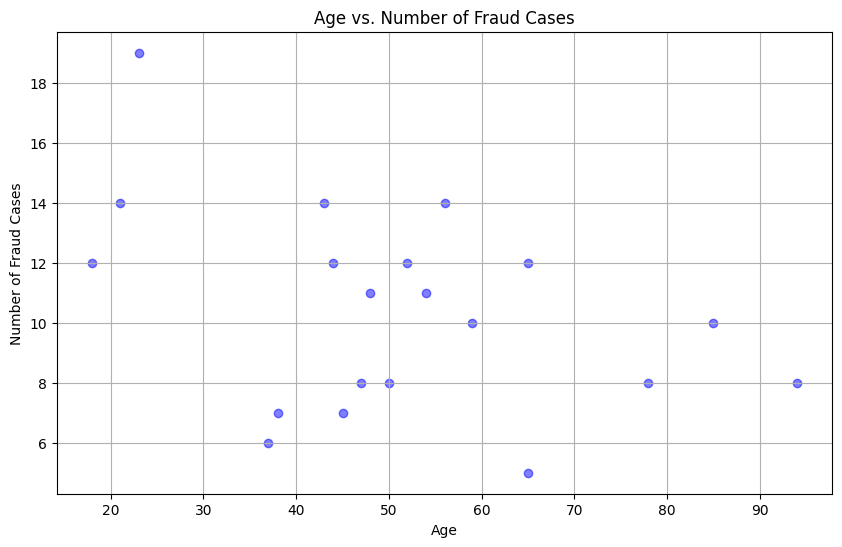

In [60]:
# Age vs. Fraud cases
# Create a scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(query_df4['age'], query_df4['no_of_fraud'], color='blue', alpha=0.5)

# Adding plot title and labels
plt.title('Age vs. Number of Fraud Cases')
plt.xlabel('Age')
plt.ylabel('Number of Fraud Cases')

# Showing the plot
plt.grid(True)
plt.show()

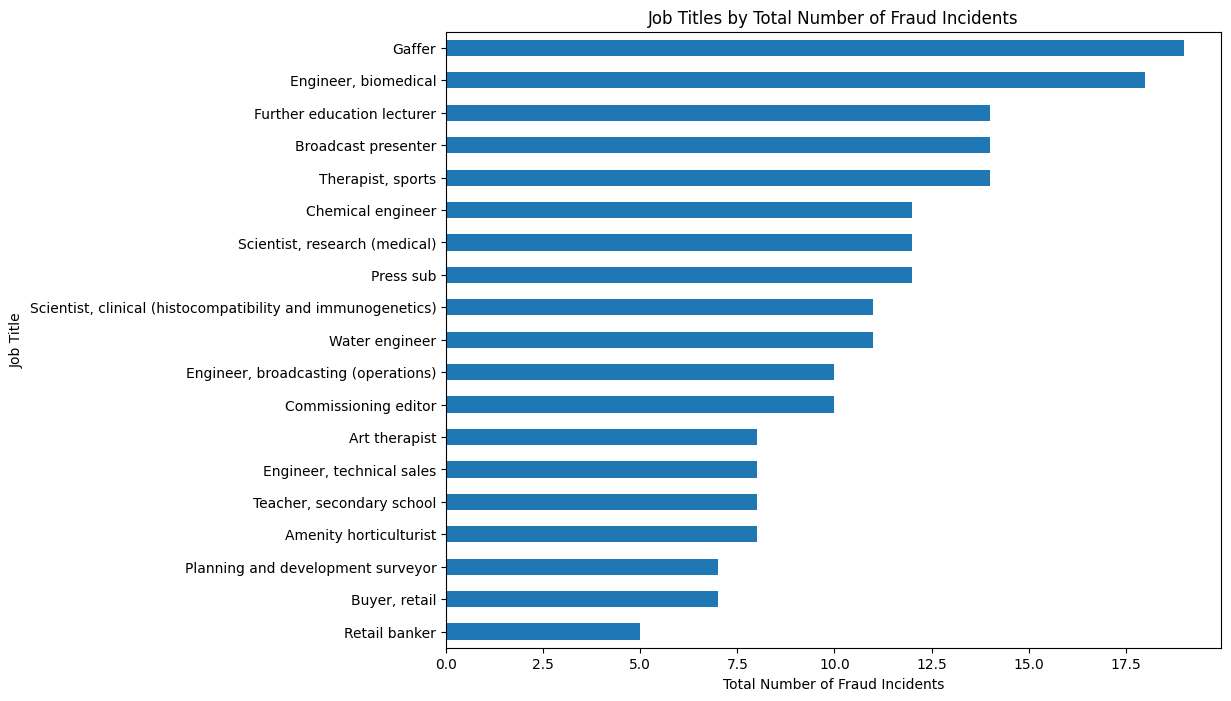

In [46]:
# Bar Chart of Fraud Incidents by Job Title
query_df4.groupby('c_job')['no_of_fraud'].sum().sort_values(ascending=False).plot(kind='barh', figsize=(10, 8))
plt.title('Job Titles by Total Number of Fraud Incidents')
plt.xlabel('Total Number of Fraud Incidents')
plt.ylabel('Job Title')

# Invert the y-axis to have the job with the most incidents at the top
plt.gca().invert_yaxis()

(array([0, 1]), [Text(0, 0, 'F'), Text(1, 0, 'M')])

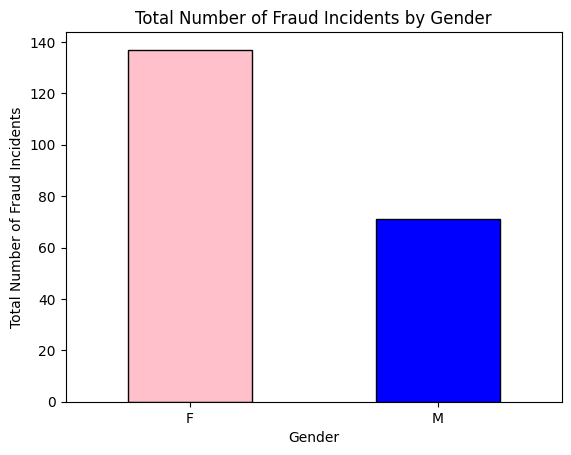

In [62]:
# Bar Chart of Fraud Incidents by Gender
# Comparing the number of fraud incidents between genders using a bar chart

query_df4.groupby('c_gender')['no_of_fraud'].sum().plot(kind='bar', color=['pink', 'blue'], edgecolor='k')
plt.title('Total Number of Fraud Incidents by Gender')
plt.xlabel('Gender')
plt.ylabel('Total Number of Fraud Incidents')
plt.xticks(rotation=0)

### Query 5 Profiling High-Risk Transactions
#### A subquery that isolates high-risk transactions, defined as those with amounts greater than twice the average of all transactions. By focusing on these outliers, you can create a profile of what constitutes a high-risk transaction in terms of amount, location, and time.


In [48]:
#make this query 4

# creating a materialized view from query 3  named trans_cust_demo using postgreSQL since python keeps hanging and using this materialized view in query 5

mat_view = """
            SELECT * FROM trans_cust_demo;

"""

In [49]:
mat_viewdf = pd.read_sql_query(mat_view, engine)
mat_viewdf

,customer_id,c_gender,c_job,merch_name,trans_num,trans_category_type,trans_date_time,trans_amt,median_trans_amt,percentage_diff,trans_is_fraud
0,163011,F,"Engineer, control and instrumentation",Kozey-McDermott,93dd11ae955df7ea72df575dc091ac82,travel,2020-12-27 15:58:00,22768.11,35.46,High Risk,False
1,49735544,F,Higher education careers adviser,Corwin-Romaguera,932aef04df2c7a1f4d53127eb1bd71f2,travel,2020-12-22 21:30:00,21437.71,50.43,High Risk,False
2,64061725,M,Hospital doctor,Kovacek Ltd,88d5f18471024a72f0937f7a628327f9,travel,2020-11-27 14:54:00,19364.91,52.54,High Risk,False
3,89989635,F,Health physicist,Johnston-Casper,ba246b12f894ab083706e72f9d90ad15,travel,2020-09-21 12:02:00,16837.08,56.26,High Risk,False
4,83765334,M,Surgeon,Boyer-Haley,787b3a6dae2fad86d24e89ec9e13482b,travel,2020-12-16 21:16:00,16339.26,22.96,High Risk,False
...,...,...,...,...,...,...,...,...,...,...,...
555714,67413170,F,"Engineer, aeronautical","Parker, Nolan and Trantow",bea3297f5943f352aec57617558a8a0e,entertainment,2020-08-10 02:20:00,1.00,56.71,Within Range,False
555715,93323632,F,Colour technologist,Goldner-Lemke,c8d80b45a15817bd84715aff60c3815d,entertainment,2020-08-03 20:46:00,1.00,30.49,Within Range,False
555716,24224792,M,"Chemist, analytical",Botsford Ltd,944803d7e709b5de574670d600e965c0,shopping pos,2020-08-02 18:33:00,1.00,34.48,Within Range,False
555717,94198392,F,Podiatrist,"Bernier, Volkman and Hoeger",a1861032dc637bd885d127d289c8d3fd,misc net,2020-07-31 19:32:00,1.00,21.40,Within Range,False


In [50]:
query5 = """
            SELECT 
                tr.trans_category_type,
                EXTRACT(MONTH FROM tr.trans_date_time) AS transaction_month, 
                COUNT(CASE WHEN tr.trans_is_fraud = True THEN 1 END) AS total_fraud_cases,
                COUNT(CASE WHEN tr.c_gender = 'M' THEN 1 END) AS total_male_involved,
                COUNT(CASE WHEN tr.c_gender = 'F' THEN 1 END) AS total_female_involved,
                PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY tr.trans_amt) AS med_fraud_amt,
                tr.merch_name,
                m.merch_lat,
                m.merch_long
            FROM 
                trans_cust_demo tr
                JOIN transaction t ON tr.trans_num = t.trans_num
                JOIN merchant m ON t.merchant_id = m.merchant_id
            WHERE 
                tr.trans_is_fraud = True 
            GROUP BY 
                tr.trans_category_type, 
                transaction_month, 
                tr.merch_name, 
                m.merch_lat, 
                m.merch_long
            HAVING 
                COUNT(CASE WHEN tr.trans_is_fraud = True THEN 1 END) >= 1
            ORDER BY 
                total_fraud_cases DESC;

"""

In [51]:
query_df5 = pd.read_sql_query(query5, engine)
query_df5

,trans_category_type,transaction_month,total_fraud_cases,total_male_involved,total_female_involved,med_fraud_amt,merch_name,merch_lat,merch_long
0,grocery pos,8.0,6,1,5,330.490,Cole PLC,40.325204,-79.237092
1,shopping net,7.0,6,3,3,963.375,Jast Ltd,37.963992,-82.926133
2,shopping net,10.0,5,1,4,977.080,"Mosciski, Ziemann and Farrell",38.709403,-104.012066
3,grocery pos,10.0,5,2,3,317.370,Padberg-Welch,44.732656,-109.444699
4,grocery pos,10.0,5,3,2,291.240,Kiehn Inc,32.988015,-80.955716
...,...,...,...,...,...,...,...,...,...
1440,kids pets,10.0,1,0,1,20.610,Nolan-Williamson,34.849935,-86.922332
1441,kids pets,10.0,1,0,1,21.230,"Roberts, Daniel and Macejkovic",31.212812,-85.081825
1442,kids pets,10.0,1,0,1,20.730,"Streich, Rolfson and Wilderman",39.296040,-76.368333
1443,kids pets,10.0,1,0,1,21.090,Weimann-Lockman,41.881426,-83.316455


In [52]:
# Create a map centered at an average location to initially position the map at the center where the merchants are located
m = folium.Map(location=[query_df5['merch_lat'].mean(), query_df5['merch_long'].mean()], zoom_start=5)

# Add points to the map
for idx, row in query_df5.iterrows():
    # Determine the color based on the transaction category type
    if row['trans_category_type'].endswith('pos'):
        color = 'red'
    elif row['trans_category_type'].endswith('net'):
        color = 'blue'
    else:
        color = 'green'  # Use green for other categories

    folium.Marker(
        location=[row['merch_lat'], row['merch_long']],
        popup=(
            f"{row['merch_name']}: {row['total_fraud_cases']} fraud cases, "
            f"Median Amount: ${row['med_fraud_amt']}"
        ),
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(m)

# Display the map
m


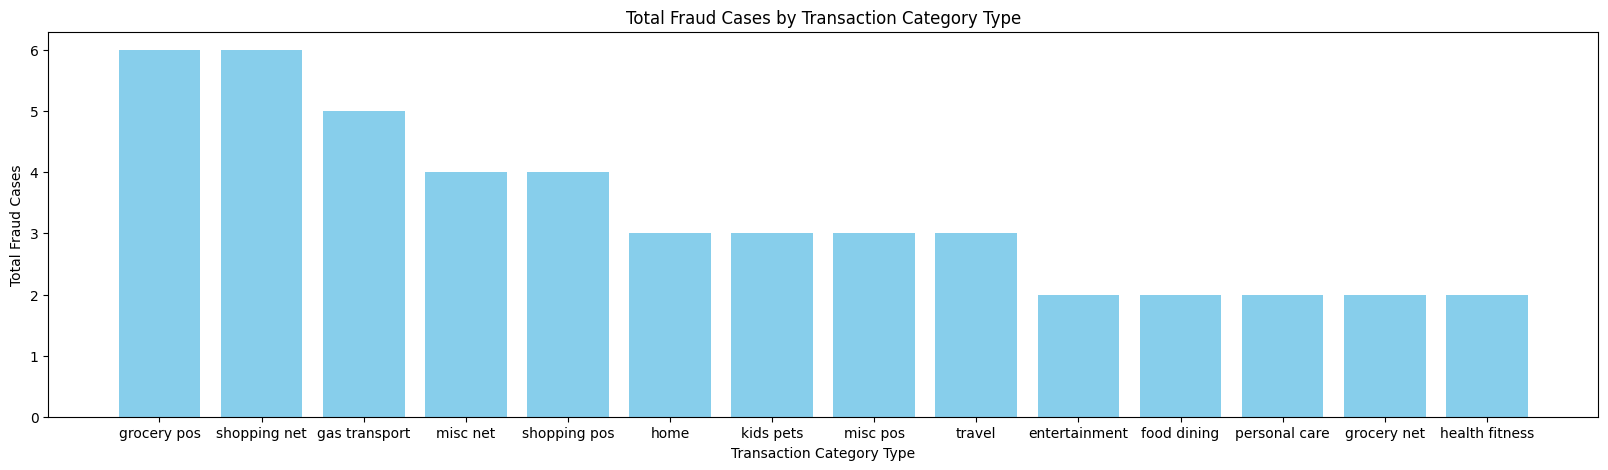

In [54]:


plt.figure(figsize=(20, 5))
bar_plot = plt.bar(query_df5['trans_category_type'], query_df5['total_fraud_cases'], color='skyblue')

plt.xlabel('Transaction Category Type')
plt.ylabel('Total Fraud Cases')
plt.title('Total Fraud Cases by Transaction Category Type')
plt.xticks(rotation=0)
plt.show()


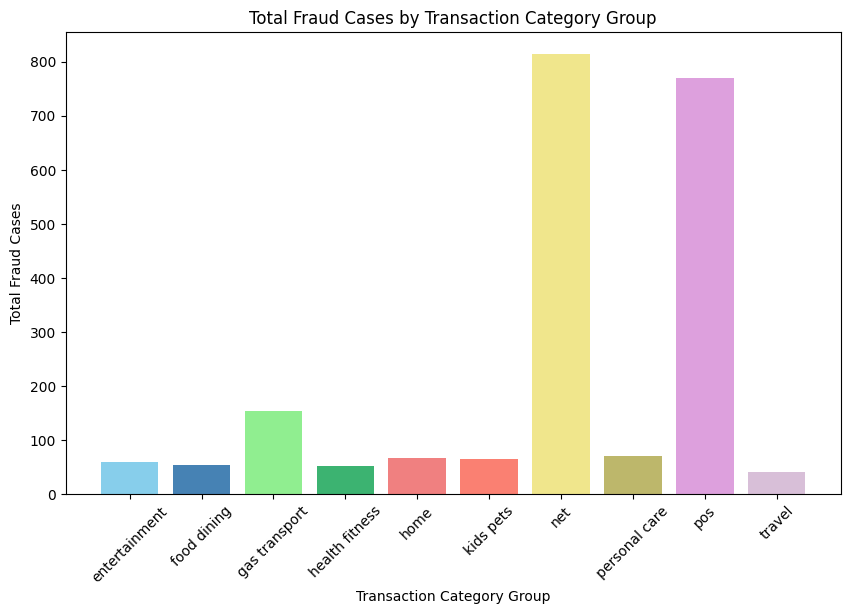

In [57]:
#group shopping pos, grocery pos, misc pos as pos and shopping net, misc net, grocery net as net

query_df5['cat_group'] = query_df5['trans_category_type'].apply(
    lambda x: 'pos' if x.endswith('pos') else ('net' if x.endswith('net') else x)
)

# Grouping by the 'cat_group' column and summing the total fraud cases
grouped_df = query_df5.groupby('cat_group', as_index=False)['total_fraud_cases'].sum()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(grouped_df['cat_group'], grouped_df['total_fraud_cases'], color = ['skyblue', 'steelblue', 'lightgreen', 'mediumseagreen', 'lightcoral',
          'salmon', 'khaki', 'darkkhaki', 'plum', 'thistle'])

plt.xlabel('Transaction Category Group')
plt.ylabel('Total Fraud Cases')
plt.title('Total Fraud Cases by Transaction Category Group')
plt.xticks(rotation=45) 
plt.show()

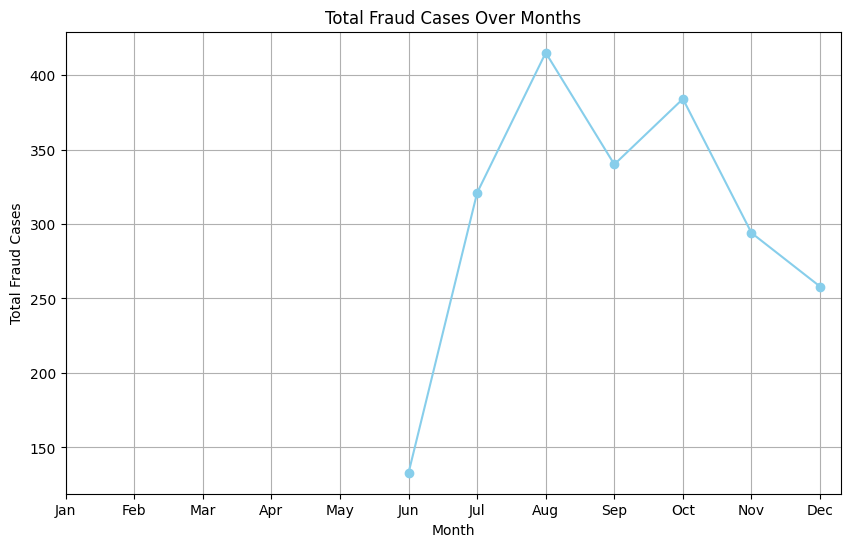

In [56]:
df_months_fraud = query_df5[['transaction_month', 'total_fraud_cases']]
# Group by month and sum the fraud cases
df_grouped = df_months_fraud.groupby('transaction_month').sum().reset_index()
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['transaction_month'], df_grouped['total_fraud_cases'], marker='o', linestyle='-', color='skyblue')

plt.xlabel('Month')
plt.ylabel('Total Fraud Cases')
plt.title('Total Fraud Cases Over Months')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)  

plt.show()

# References:
Connecting PostgreSQL with SQLAlchemy in Python
https://www.geeksforgeeks.org/connecting-postgresql-with-sqlalchemy-in-python/

How to plot a Pandas Dataframe with Matplotlib?
https://www.geeksforgeeks.org/how-to-plot-a-pandas-dataframe-with-matplotlib/

Pandas - Plotting
https://www.w3schools.com/python/pandas/pandas_plotting.asp

Visualization with Seaborn
https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html

Creating a Simple Map with Folium and Python
https://towardsdatascience.com/creating-a-simple-map-with-folium-and-python-4c083abfff94

How to handle time series data with ease using pandas datetime properties
https://pandas.pydata.org/docs/getting_started/intro_tutorials/09_timeseries.html

Time Series Plot or Line plot with Pandas
https://www.geeksforgeeks.org/time-series-plot-or-line-plot-with-pandas/

Data Manipulation with Pandas
https://www.codecademy.com/learn/data-manipulation-in-python-dvp/modules/pandas-dvp/cheatsheet

Manipulating DataFrames with Pandas – Python
https://www.geeksforgeeks.org/manipulating-dataframes-with-pandas-python/

Pandas Tutorial: DataFrames in Python
https://www.datacamp.com/tutorial/pandas-tutorial-dataframe-python